In [3]:
pip install fuzzywuzzy

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [0]:
#import important libraries
from fuzzywuzzy import process
import re

In [0]:
path = "drive/My Drive/data/"

customer_df = pd.read_csv(path + 'customer.csv')
invoice_df = pd.read_csv(path + 'invoice.csv')
jtd_df = pd.read_csv(path + 'jtd.csv')
plant_df = pd.read_csv(path + 'plant.csv')
vehicles_df = pd.read_csv(path + 'vehicles.csv')

In [0]:
# 1. drop unwanted columns from all dataframes
# 2. lowercase all the categorical columns

def drop_col(dataset, col_to_drop):
    dataset.drop(col_to_drop, axis=1, inplace=True)
    return dataset

def lowercase(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    for col in categorical_col:
        dataset[col] = dataset[col].map(lambda x: x if type(x)!=str else x.lower())
    return dataset

invoice_columns_to_drop = ['Unnamed: 0', 'Amt Rcvd From Custom', 'Amt Rcvd From Ins Co','Area / Locality',
                           'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)',
                           'IGST(12%)', 'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'Insurance Company',
                           'Outstanding Amt', 'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)', 'SGST/UGST(9%)',
                           'Service Advisor Name', 'TDS amount', 'Total CGST', 'Total GST', 'Total IGST',
                           'Total SGST/UGST','Plant Name1','Recovrbl Exp']
customer_columns_to_drop = ['Unnamed: 0','Death date']
plant_columns_to_drop = ['Unnamed: 0','Name 1','Factory calendar','Valuation Area',
                         'Customer no. - plant','PO Box','Postal Code','Name 2',
                         'Vendor number plant','House number and street']
jtd_columns_to_drop = ['Unnamed: 0']
vehicles_columns_to_drop = ['Unnamed: 0','Product GUID']

dataframes = [invoice_df, customer_df, plant_df, jtd_df, vehicles_df]
dataframe_columns_to_drop = [invoice_columns_to_drop, customer_columns_to_drop, plant_columns_to_drop, jtd_columns_to_drop, vehicles_columns_to_drop]

for i in range(len(dataframes)):
  dataframes[i] = drop_col(dataframes[i],dataframe_columns_to_drop[i])
  dataframes[i] = lowercase(dataframes[i])

In [0]:

# Preprocessing for dataset merge operation

# 1. Remove leading zeros from 'Customer No.' column
def remove_leading_zeros(dataset,cols):
    for col in cols:
      dataset[col] = dataset[col].astype(str).apply(lambda x: x.lstrip("0"))
    return dataset
invoice_df  = remove_leading_zeros(invoice_df,['Customer No.'])
customer_df = remove_leading_zeros(customer_df,['Customer No.'])


# 2. Rename columns to use them as key column for merge operation
def rename_columns(dataset, rename_cols_dict):
    dataset.rename(columns=rename_cols_dict, inplace=True)
    return dataset
dict_invoice_df = {'District':'State'}
dict_vehicles_df = {'Vehicle Model':'Make', 'License Plate Number':'Regn No'}

invoice_df  = rename_columns(invoice_df, dict_invoice_df)
vehicles_df = rename_columns(vehicles_df, dict_vehicles_df)


# 3. Replace values in key columns for merge operation
def replacement(dataset, col, dict_replacement, regex=False):
    dataset[col] = dataset[col].replace(dict_replacement, regex=regex )
    return dataset
make_replacements = {
                    'mahindra &  mahindra': 'mahindra',
                    'tata motors': 'tata',
                    'maruti suzuki': 'maruti',
                    'mercedes benz': 'mercedes-benz',
                    'porche': 'porsche',
                    'land rover' : 'rover',
                    'mitsubishi motors':'mitsubishi motor',
                    'premier\xa0automobiles': 'premierauto'
                    }
pattern_replacement = {'z_':''}
vehicles_df = replacement(vehicles_df, 'Make', pattern_replacement, regex=True)
vehicles_df = replacement(vehicles_df, 'Make', make_replacements)
invoice_df  = replacement(invoice_df, 'Make', make_replacements)

In [0]:
# invoice_df['Invoice Date']=pd.to_datetime(invoice_df['Invoice Date'])

# invoice_df['year']=invoice_df['Invoice Date'].dt.year
# invoice_df['month']=invoice_df['Invoice Date'].dt.month

# # use unstack()
# list=['maharashtra', 'tamil Nadu', 'madhya pradesh','andhra pradesh', 'uttar pradesh', 'rajasthan']
# list2=['Karnataka','West Bengal', 'Uttarakhand', 'Odisha', 'Telangana', 'Bihar', 'Punjab', 'Haryana', 'Gujarat' ]
# invoice_df['state']=invoice_df['State']
# invoice_df['state']=invoice_df['state'].apply(lambda x:'no' if x not in list else 'yes')
# state_df=invoice_df[invoice_df['state'] == 'yes']

# fig, ax = plt.subplots(figsize=(15,7))
# state_df.groupby(['year','State'])['Total Amt Wtd Tax.'].sum().unstack().plot(ax=ax,marker='o')
# plt.title('Yearwise total amt spent in top states')

In [0]:
# Merge dataframes based on key
def merge_df(left_df, right_df, key):
    merge_df = pd.merge(left=left_df, right=right_df, how='left', on=key)
    return merge_df

invoice_customer_df = merge_df(left_df=invoice_df, right_df=customer_df,key=['Customer No.'])
invoice_customer_plant_df = merge_df(left_df=invoice_customer_df, right_df=plant_df,key=['Plant','State'])
invoice_customer_plant_vehicles_df = merge_df(left_df=invoice_customer_plant_df, right_df=vehicles_df,key=['Regn No','Make'])

master_df = invoice_customer_plant_vehicles_df

In [12]:
print("invoice_df shape: ",invoice_df.shape)
print("customer_df shape: ",customer_df.shape)
print("invoice_customer_df shape: ",invoice_customer_df.shape)
print("plant_df shape: ",plant_df.shape)
print("invoice_customer_plant_df shape: ",invoice_customer_plant_df.shape)
print("vehicles_df shape: ",vehicles_df.shape)
print("invoice_customer_plant_vehicles_df shape: ",invoice_customer_plant_vehicles_df.shape)

invoice_df shape:  (984741, 33)
customer_df shape:  (555338, 8)
invoice_customer_df shape:  (984741, 40)
plant_df shape:  (438, 4)
invoice_customer_plant_df shape:  (984741, 42)
vehicles_df shape:  (588761, 3)
invoice_customer_plant_vehicles_df shape:  (992903, 43)


In [0]:
# fill missing values of 'CITY' column 
master_df['CITY'].fillna(master_df['City'], inplace = True)

#remove dulicate column 'City'
master_df = drop_col(dataset=master_df, col_to_drop=['City'])

In [14]:
# Function to identify the number of missing values in every feature
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())*100/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data_master_df = missing_datas(master_df)
print("missing data for 'master_df': ")
print(missing_data_master_df[missing_data_master_df['Percent']>0.00])

missing_data_jtd_df = missing_datas(jtd_df)
print("missing data for 'jtd_df': ")
print(missing_data_jtd_df[missing_data_jtd_df['Percent']>0.00])

missing data for 'master_df': 
                      Total    Percent
Claim No.            988053  99.511533
Occupation           965665  97.256731
Cash /Cashless Type  965197  97.209597
Date of Birth        962418  96.929710
Marital Status       958174  96.502277
Gate Pass Date       946518  95.328345
Policy no.           924141  93.074651
Expiry Date          894807  90.120284
Technician Name      734250  73.949822
ODN No.              690834  69.577189
Total Value          690834  69.577189
Sales organization   279168  28.116342
Title                152663  15.375419
Fuel Type             21738   2.189338
Data Origin            7627   0.768152
Partner Type           5489   0.552823
Business Partner       3510   0.353509
Regn No                3315   0.333869
Model                  1736   0.174841
Cust Type                 4   0.000403
CITY                      3   0.000302
missing data for 'jtd_df': 
                       Total    Percent
Labor Value Number   3774033  67.159778
Tar

In [0]:
# Function to drop missing values
def drop_missing(dataset, missing, min_threshold, max_threshold):
    dataset = dataset.drop((missing[missing['Percent'] > max_threshold]).index,axis= 1)
    dataset = dataset.dropna(axis=0, subset=(missing[missing['Percent'] < min_threshold]).index)
    return dataset 

master_df  = drop_missing(master_df,missing_data_master_df,2,40)
jtd_df     = drop_missing(jtd_df,missing_data_jtd_df,2,40)

In [16]:
#recheck the missing values
new_missing_data = missing_datas(master_df)
print("missing data for 'master_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

new_missing_data = missing_datas(jtd_df)
print("missing data for 'jtd_df'")
print(new_missing_data[new_missing_data['Percent']>0.00])

missing data for 'master_df'
                     Total    Percent
Sales organization  271769  27.721998
Title               144020  14.690867
Fuel Type            18288   1.865481
missing data for 'jtd_df'
Empty DataFrame
Columns: [Total, Percent]
Index: []


In [0]:
#fill missing values with mode
def Fill_Missing_Values(dataset, cols):
    for col in cols:
      dataset[col].fillna(dataset[col].dropna().mode()[0], inplace = True)
    return dataset
  
master_df = Fill_Missing_Values(dataset=master_df,cols=['Sales organization','Title','Fuel Type'])

In [0]:
# combine Date & Time columns
def to_datetime(dataset, datetime_cols):
    for datetime in datetime_cols:
      dataset[datetime[0] + '-' + datetime[1]] = pd.to_datetime(dataset[datetime[0]]+ ' ' + dataset[datetime[1]])
    return dataset
datetime_cols = ['Invoice Date','Invoice Time','JobCard Date','JobCard Time']
master_df = to_datetime(master_df, [['Invoice Date','Invoice Time'],['JobCard Date','JobCard Time']])


#split datetime column
master_df['Year']  = master_df['Invoice Date-Invoice Time'].dt.year
master_df['Month'] = master_df['Invoice Date-Invoice Time'].dt.month


# add job duration column
def job_completion_time(dataset, start_datetime, end_datetime):
    dataset['Job_duration(in days)'] = (dataset[start_datetime] - dataset[end_datetime]) / np.timedelta64(1,'D')
    return dataset
master_df = job_completion_time(master_df, 'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time')


# add total all costs to get 'Total Expenses'
def sum_cols(dataset, cols_to_sum, result_col):
  dataset[result_col] = 0
  for col in cols_to_sum:
      dataset[result_col] = dataset[result_col] + dataset[col]
  return dataset
cost_cols     = ['Misc Total','OSL Total','Parts Total','Total Amt Wtd Tax.']
master_df =  sum_cols(master_df, cost_cols, 'Total_Expense')


#remove dulicate column Date-Time columns
master_df = drop_col(master_df, datetime_cols)
master_df = drop_col(master_df, cost_cols)

# drop unique value columns
unique_cols = ['User ID','Regn No','Pin code','Customer No.','Invoice No','Job Card No']
master_df = drop_col(master_df, unique_cols)

In [0]:
# map column description
def map_description(dataset,col, map_dict):
    dataset[col] = dataset[col].astype(str).map(map_dict)
    return dataset

data_origin_dict = { 'z001':'Camp-Outdoor','z002':'Camp-Workshop','z003':'Emailers',
                     'z004':'Fleet','z005':'Ref-Customer','z006':'Ref-Employee',
                     'z007':'Used Car Dealer','z008':'Just Dial/Other',
                     'z009':'Snapdeal/Web','z010':'Company website',
                     'z011':'Float activity','z012':'Petrol pump',
                     'z013':'Hoardings/ADVT','z014':'Insurance Co',
                     'z015':'Television AD','z016':'Newspaper AD',
                     'z017':'Newsppr leaflet','z018':'Sales Activity',
                     'z019':'Spotted outlet','z020':'M & M Employee',
                     'z021':'Outdoor Activty','z022':'Radio'
                  }

partner_type_dict = {'1.0':'Retail','2.0':'Corporate','3.0':'Fleet',
                     '4.0':'Employee','9001.0':'Insurance Company',
                     '9002.0':'Surveyor','9003.0':'Contact Person'
                    }

master_df = map_description(master_df,'Data Origin', data_origin_dict)
master_df = map_description(master_df,'Partner Type', partner_type_dict)

# change columns dtype

def modify_col_type(dataset, col, dtype):
    dataset[col] = dataset[col].astype(dtype)
    return dataset

master_df = modify_col_type(master_df, 'Fuel Type', int)

In [20]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

numeric_columns_master_df = numeric_features(master_df)
print("Numeric Features for master_df:")
print(numeric_columns_master_df)

numeric_columns_jtd_df = numeric_features(jtd_df)
print("Numeric Features for jtd_df:")
print(numeric_columns_jtd_df)

print("===="*30)

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns_master_df = categorical_features(master_df)
print("Categorical Features for master_df:")
print(categorical_columns_master_df)

categorical_columns_jtd_df = categorical_features(jtd_df)
print("categorical Features for jtd_df:")
print(categorical_columns_jtd_df)

Numeric Features for master_df:
Index(['KMs Reading', 'Labour Total', 'Title', 'Fuel Type', 'Year', 'Month',
       'Job_duration(in days)', 'Total_Expense'],
      dtype='object')
Numeric Features for jtd_df:
Index(['DBM Order', 'Order Item', 'Order Quantity', 'Net value'], dtype='object')
Categorical Features for master_df:
Index(['CITY', 'Cust Type', 'State', 'Gate Pass Time', 'Make', 'Model',
       'Order Type', 'Plant', 'Print Status', 'Business Partner',
       'Partner Type', 'Data Origin', 'Sales organization',
       'Invoice Date-Invoice Time', 'JobCard Date-JobCard Time'],
      dtype='object')
categorical Features for jtd_df:
Index(['Material', 'Description', 'Item Category', 'Target quantity UoM'], dtype='object')


In [0]:
def display_unique_values(dataset, categirical_cols):
    print("Unique values: ")  
    for col in categirical_cols:
          print("{} : {}".format(col, dataset[col].unique()))
    return None
  
# display_unique_values(master_df, categorical_columns_master_df)   

# **Univariate Analysis**

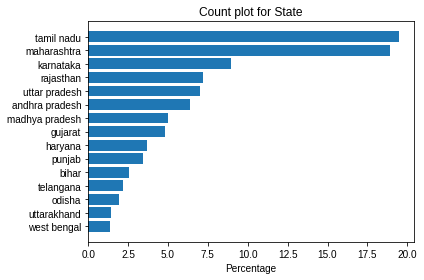

In [22]:
def plot_CountPlot(dataset,col,title=None):
    filtered_df = dataset[col].value_counts()
    filtered_df=filtered_df.reset_index()
    filtered_df[col] = (filtered_df[col]/sum(filtered_df[col]))*100
    filtered_df = filtered_df.sort_values(col)
    filtered_df = filtered_df[filtered_df[col]>1]
    plt.barh(filtered_df['index'],filtered_df[col])
    
    plt.style.use('seaborn')
    if(title==None):
        plt.title('Count plot for {}'.format(col))
    plt.xlabel('Percentage')
    plt.tight_layout()
    plt.show()
  
# plot_vc(master_df,'Data Origin','how customers know abt MFCS')
# plot_vc(master_df,'Make','Make wise distribution')
plot_CountPlot(master_df,'State')
# plot_vc(master_df[master_df['State'] == 'maharashtra'],'CITY','Citywise distribution in maharashtra')
# plot_vc(master_df[master_df['State'] == 'tamil nadu'],'CITY','Citywise distribution in TN')
# plot_vc(master_df,'Order Type','Order type distribution')
# plot_vc(master_df[master_df['State'] == 'maharashtra'],'Plant Name1','plant wise distribution in maharashtra')

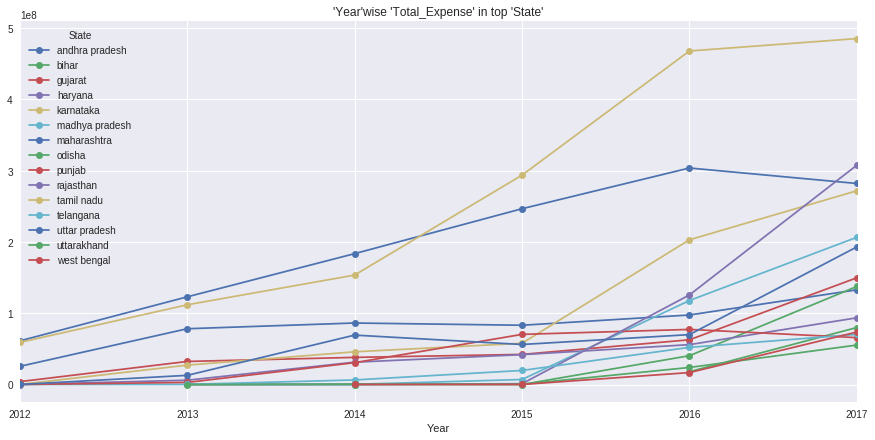

In [23]:
def get_top_values(dataset,col,min_percentage):
    filtered_df = dataset[col].value_counts()
    filtered_df=filtered_df.reset_index()
    filtered_df[col] = (filtered_df[col]/sum(filtered_df[col]))*100
    filtered_df = filtered_df.sort_values(col)
    filtered_df = filtered_df[filtered_df[col]>min_percentage]
    top_values  = filtered_df['index'].tolist()
    top_values_df = dataset[dataset[col].isin(top_values)]
    return top_values_df, top_values

def plot_TimeSeries(dataset, time_col, cat_col, num_col):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.title("'{}'wise '{}' in top '{}'".format(time_col, num_col, cat_col))
    dataset.groupby([time_col,cat_col])[num_col].sum().unstack().plot(ax=ax,marker='o')
    
top_state_df, top_state = get_top_values(master_df, 'State',1)
plot_TimeSeries(top_state_df,'Year','State','Total_Expense')

In [24]:
print("columns from invoice_df: ",set(master_df.columns) & set(invoice_df.columns))
print("columns from customer_df: ",set(master_df.columns) & set(customer_df.columns))
print("columns from plant_df: ",set(master_df.columns) & set(plant_df.columns))
print("columns from vehicles_df: ",set(master_df.columns) & set(vehicles_df.columns))

columns from invoice_df:  {'CITY', 'Order Type', 'KMs Reading', 'Plant', 'Cust Type', 'Print Status', 'State', 'Model', 'Gate Pass Time', 'Labour Total', 'Make'}
columns from customer_df:  {'Title', 'Partner Type', 'Data Origin', 'Business Partner'}
columns from plant_df:  {'Sales organization', 'State', 'Plant'}
columns from vehicles_df:  {'Make', 'Fuel Type'}


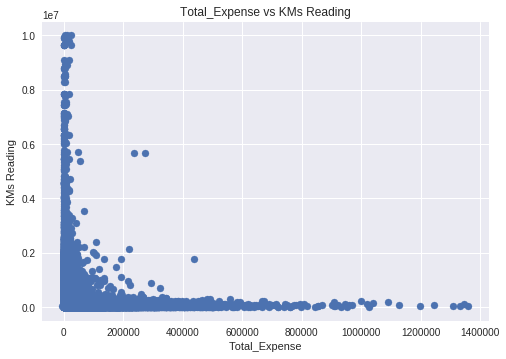

In [25]:
def scatter_plot(df,x,y):
  plt.style.use('seaborn')
  plt.scatter(df[x],df[y])
  #cbar=plt.colorbar()
  #cbar.set_label('Price variation')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.title('{} vs {}'.format(x,y))
  plt.show()

scatter_plot(master_df,'Total_Expense','KMs Reading')

Index(['fiat', 'ford', 'general motors', 'honda', 'hyundai', 'mahindra',
       'maruti', 'renault', 'skoda', 'tata', 'toyota', 'volkswagen'],
      dtype='object', name='Make')


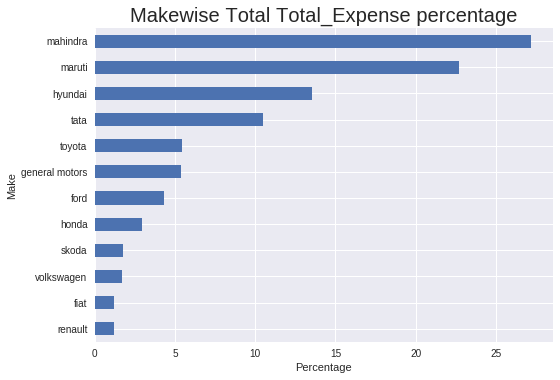

In [26]:
def plot_groupby(df,grpby_col, col):
  gp=df.groupby(grpby_col)[col].sum()
  gp=100*gp/sum(gp)
  gp=gp[gp>1]
  print(gp.index)
  gp.sort_values().plot(kind='barh')
  plt.style.use('fivethirtyeight')
  plt.title('{}wise Total {} percentage'.format(grpby_col, col))
  plt.xlabel('Percentage')
  plt.tight_layout()

plot_groupby(master_df,'Make','Total_Expense')

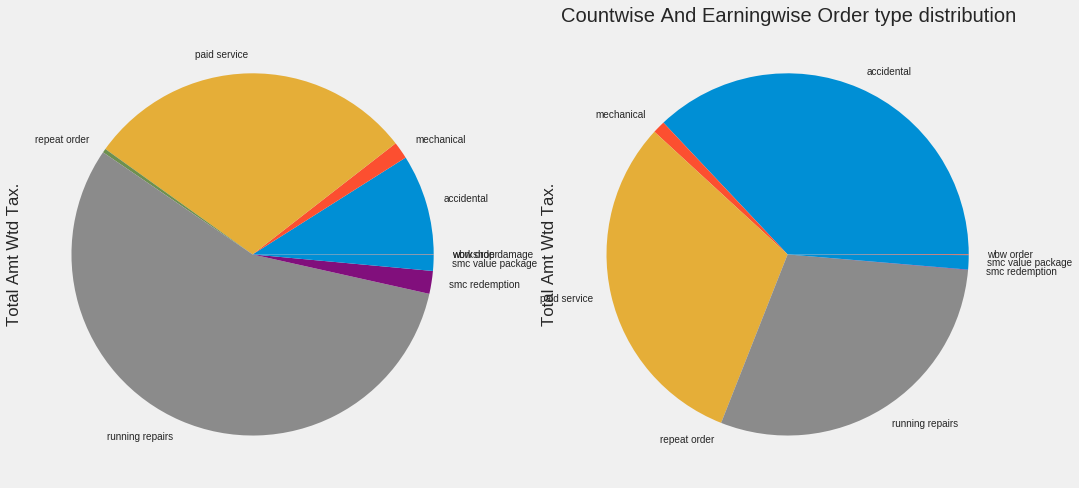

In [27]:
fig,ax = plt.subplots(1,2,figsize=(15,7))
plt.style.use('fivethirtyeight')
invoice_df.groupby('Order Type')['Total Amt Wtd Tax.'].count().plot(kind='pie',ax=ax[0])
plt.title('Countwise And Earningwise Order type distribution',loc='left')
invoice_df.groupby('Order Type')['Total Amt Wtd Tax.'].sum().plot(kind='pie',ax=ax[1])
plt.tight_layout()
#plt.legend(loc='upper right')
plt.show()

In [0]:
# import sys
digits = []
correct_string = []
corrected_string = []
error_string = []
punctuation_string = []
not_corrected_string = []
top_city_df, top_cities = get_top_values(master_df, 'CITY',0.6)
top_cities.remove('nasik')

def spellcorrect(string):
      if (string.isdigit()):
              digits.append(string)
              string = np.nan
      elif(bool(re.match('[a-zA-Z]', string))):
          best_guess = process.extractOne(string, top_cities)
          if(len(string.split())<=2):
              if(best_guess[1]==100):
                  correct_string.append(string)
              elif(best_guess[1]>=80):
                  corrected_string.append(string)
                  string = best_guess[0]
              else:
                  not_corrected_string.append(string)
          elif(len(string.split())>2):
              if(best_guess[1]>=70):
                    corrected_string.append(string)
                    string = best_guess[0]
              else:
                  error_string.append(string)
                  string = np.nan
      else:
            punctuation_string.append(string)
            string = np.nan
      return string
          
def typo_check(dataset,col): 
    dataset[col] = dataset[col].apply(spellcorrect)
    return dataset
  
cities_df = typo_check(master_df, 'CITY')

# not_corrected.sort()
# digits.sort()
# corrected_string.sort()

In [0]:
# user_input = "bangalore"
# best_guess = process.extractOne(user_input, top_cities)
# if(best_guess[1]>67):
#     print(f"The best match for '{user_input}' is '{best_guess[0]}' which is a {best_guess[1]}% match.")

In [0]:
digits = sorted(set(digits))
correct_string = sorted(set(correct_string))
corrected_string = sorted(set(corrected_string))
not_corrected_string = sorted(set(not_corrected_string))
error_string = sorted(set(error_string))
punctuation_string = sorted(set(punctuation_string))

In [31]:
print(len(digits))
print(len(correct_string))
print(len(corrected_string))
print(len(error_string))
print(len(punctuation_string))
print(len(not_corrected_string))

110
66
2166
3136
500
20906


In [32]:
from google.colab import files

cities_df.to_csv('cities_df.csv', index=False)
files.download('cities_df.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 37556, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

KeyboardInterrupt: ignored